# Robot dance: a city-wise automatic control of Covid-19 mitigation levels

Robot dance is an automatic control system that considers a complex network of cities with working mobility between them during the period of an epidemic. 
It proposes a control framework that suggests the level of protective measures, in order to avoid the collapse of the health system. 
The model is the following: let a graph with $K$ cities, each one with population $N_i$, and

$$
S_i + E_i + I_i + R_i = 1, i=1,\dots,K.
$$

Let $\alpha(t)$ be a binary coefficient function with $\alpha(t) = 1$ in the time spent at the original node and $\alpha(t) = 0$ during the day. 
Set $T_{\mathrm{inc}}$ and $T_{\mathrm{inf}}$ the incubation and the infection periods. 
During the night, the system works as a SEIR model, written as

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i,
\end{split}
$$

But the cities have commuting, which changes the dynamic of infections.
Let $p_{ij}$ represent the percentage of individuals of node $i$ that work at $j$.
The orginal model consideres that $p_{ij}(t)$ is a function of the time which decreases linearly with $r_j(t)$. 
Here we treat it as a constant.
During the day, the effective population at $i$ is $P_i^{\mathrm{eff}} = \sum_{j=1}^K p_{ji} N_j$.

The number of working people from $i$ that get exposed to infectious individuals from $j$ is 

$$
p_{ij} S_i(t) I_j^{\mathrm{eff}}(t),
$$

where the effective infection ratio is 

$$
I_j^{\mathrm{eff}}(t) = \frac{1}{P_j^{\mathrm{eff}}} \sum_{k=1}^K p_{kj} I_k N_k,
$$

that represents the number of incoming infected individuals from the other cities to $j$ normalized by the effective population there. 

The equations are, therefore, 

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) + (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i.
\end{split}
$$

We can say that $r_i(t) = \beta_i(t)/\gamma = \beta_i(t) T_{\mathrm{inf}}$.
The variable $r_j(t)$ is the control variable that means the reproductive number at time $t$ at city $j$.
They minimize a function changing this function. 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp
from scipy.sparse.linalg import eigs

Model code

In [40]:
def model_ode(t, y, alpha, beta, tau, gamma, population, p_matrix, population_eff, K):
    S, E, I, R = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha(t) * beta * S * I - (1-alpha(t)) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - tau * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I
    return np.hstack([S_dot, E_dot, I_dot, R_dot])

def hour_to_day(y, n_days):
    v = np.zeros((y.shape[0], n_days))
    values_per_day = int(y.shape[1]/n_days)
    for i in range(n_days):
        v[:,i] = np.mean(y[:,values_per_day*i:values_per_day*(i+1)], axis=1)
    return v

Here we consider a centralised city with its ramifications.
The big city is the center of the network. 
We suppose that 

$p_{0j} = 0.01, j = 1, \dots, K-1$, that is, one percent of the big city population goes to small city $j$.
Moreover, we suppose that $p_{j0} = 0.4$, that is, $40\%$ of the small cities go to the center.

In [61]:
K = 5
population = np.array([1e6, 1e4, 1e4, 1e4, 1e4])

p_0j = 0.01
p_j0 = 0.4


p_matrix = np.array([
    [1-4*p_0j, p_0j, p_0j, p_0j, p_0j],
    [p_j0, 1-p_j0, 0, 0, 0],
    [p_j0, 0, 1-p_j0, 0, 0],
    [p_j0, 0, 0, 1-p_j0, 0],
    [p_j0, 0, 0, 0, 1-p_j0]
])
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = lambda t: 1.0 if t % 24 < 6 or t % 24 > 18 else 0.0
beta = np.array([0.5, 0.4, 0.4, 0.4, 0.4]) / 24
tau = 1/(5.2 * 24)
gamma = 1/(2.9 * 24)

Initial conditions: 

$I_0(0) = 100/\phi_0, I_j(0) = 0$

In [62]:
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 100/1e6
y0[0] = 1-y0[K]

In [63]:
n_days = 300
t_eval = np.linspace(0, 24 * n_days, 100 * n_days)

sol = solve_ivp(fun=model_ode,
                t_span=(0,24 * n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
                args = (alpha, beta, tau, gamma, population, p_matrix, population_eff, K)
               )

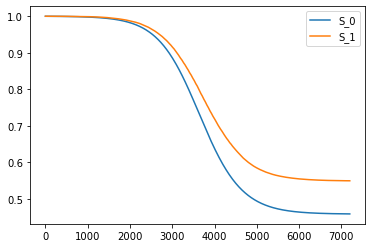

In [64]:
plt.plot(sol.t, sol.y[0], label='S_0')
plt.plot(sol.t, sol.y[1], label='S_1')
plt.legend()
plt.show()

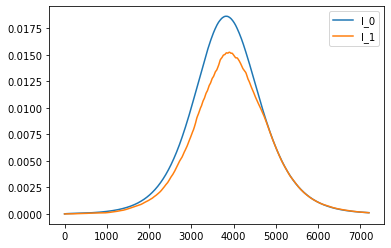

In [65]:
plt.plot(sol.t, sol.y[2*K], label='I_0')
plt.plot(sol.t, sol.y[2*K+2], label='I_1')
plt.legend()
plt.show()

Now, with different rates of commuting.

In [82]:
K = 5
population = np.array([1e6, 1e4, 1e4, 1e4, 1e4])

p_0j = 0.4
p_j0 = 0.01


p_matrix = np.array([
    [1-4*p_0j, p_0j, p_0j, p_0j, p_0j],
    [p_j0, 1-p_j0, 0, 0, 0],
    [p_j0, 0, 1-p_j0, 0, 0],
    [p_j0, 0, 0, 1-p_j0, 0],
    [p_j0, 0, 0, 0, 1-p_j0]
])
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = lambda t: 1.0 if t % 24 < 6 or t % 24 > 18 else 0.0
beta = np.array([0.5, 0.4, 0.4, 0.4, 0.4]) / 24
tau = 1/(5.2 * 24)
gamma = 1/(2.9 * 24)

In [83]:
n_days = 300
t_eval = np.linspace(0, 24 * n_days, 100 * n_days)

sol = solve_ivp(fun=model_ode,
                t_span=(0,24 * n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
                args = (alpha, beta, tau, gamma, population, p_matrix, population_eff, K)
               )

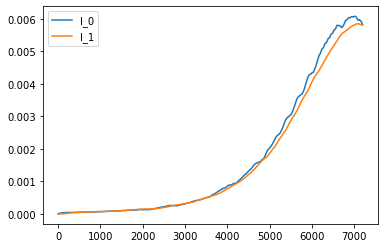

In [84]:
plt.plot(sol.t, sol.y[2*K], label='I_0')
plt.plot(sol.t, sol.y[2*K+2], label='I_1')
plt.legend()
plt.show()